In [18]:
from ultralytics import YOLO
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import cv2
import numpy as np

In [7]:
# Carga el modelo
model = YOLO('best.pt') 

In [8]:
print(model)

In [23]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith((".png", ".jpg", ".jpeg")):  
            img_path = os.path.join(folder, filename)
            try:
                with Image.open(img_path) as img:
                    images.append(img.copy())  # Utilizamos copy para asegurarnos de que la imagen se cierra después de cargarla
            except Exception as e:
                print(f"Error al cargar la imagen {filename}: {e}")
    return images

In [24]:
folder_path = r'C:\Users\ferna\OneDrive\Escritorio\MATERIAS\Human Perception in Computer Vision (MAR24-AGOS24)\Unidad 3\Deberes\PROYCETO\MODELO-PRACTICO\AnalisisModelo\setPruebas'
images = load_images_from_folder(folder_path)
print(f"Total de imágenes cargadas: {len(images)}")

Total de imágenes cargadas: 11


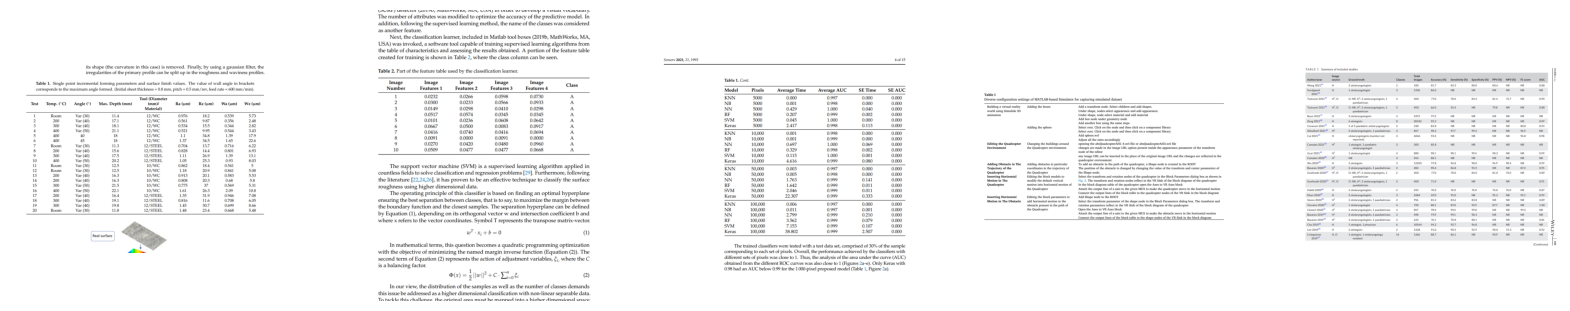

In [25]:
# Mostrar las primeras 5 imágenes cargadas
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for ax, img in zip(axes, images[:5]):  # Ajusta el slice según cuántas imágenes quieras mostrar
    ax.imshow(img)
    ax.axis('off')
plt.show()

In [26]:
# Función para convertir imágenes a diferentes espacios de color
def convert_color_space(image, color_space):
    if color_space == 'HSV':
        return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
    elif color_space == 'LAB':
        return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2Lab)
    else:
        return image  # Retorna la imagen original para RGB

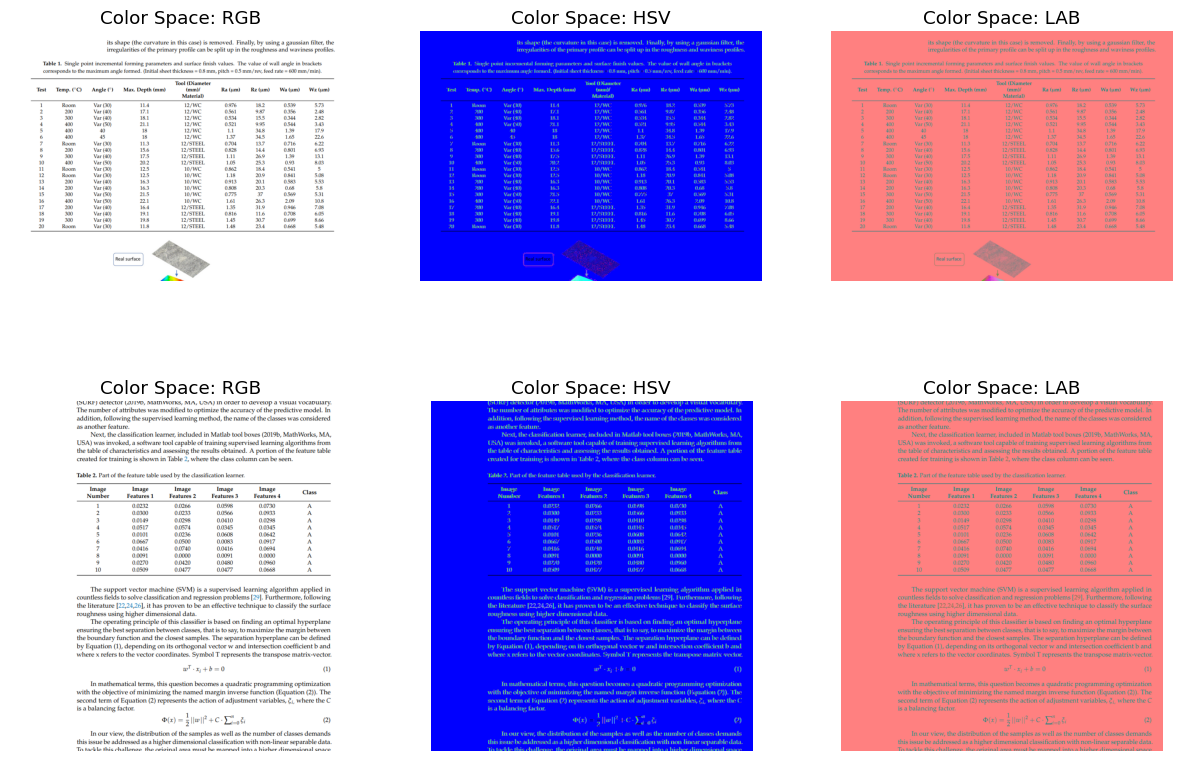

In [28]:
# Aplicar la conversión y visualizar solo las dos primeras imágenes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Ajustar el tamaño del subplot para 2 filas y 3 columnas
color_spaces = ['RGB', 'HSV', 'LAB']

for i, img in enumerate(images[:2]):  # Limitar a las dos primeras imágenes
    for j, cs in enumerate(color_spaces):
        converted_img = convert_color_space(img, cs)
        axes[i, j].imshow(converted_img)
        axes[i, j].set_title(f"Color Space: {cs}")
        axes[i, j].axis('off')
plt.show()

In [29]:
# Función para visualizar un mapa de calor de la imagen
def show_heatmap(image, ax):
    # Convertir a escala de grises
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    # Aplicar un mapa de calor
    heatmap_img = cv2.applyColorMap(gray_image, cv2.COLORMAP_HOT)
    # Mostrar la imagen
    ax.imshow(heatmap_img)
    ax.set_title("Heatmap")
    ax.axis('off')

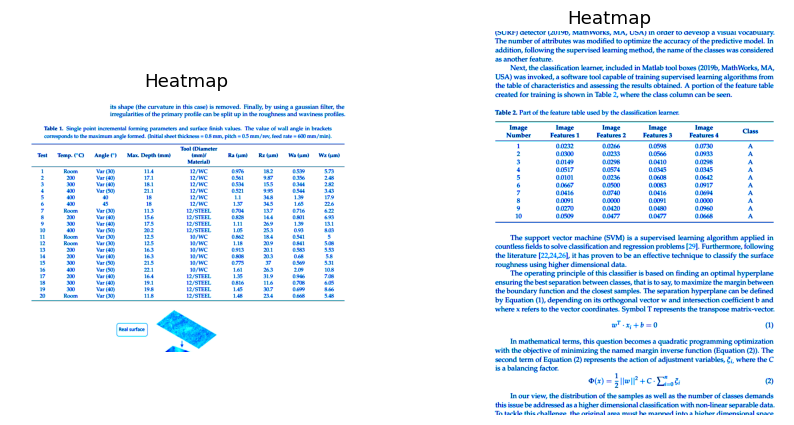

In [30]:
# Crear un subplot para visualizar las imágenes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Aplicar y mostrar el mapa de calor para las dos primeras imágenes
for i, img in enumerate(images[:2]):
    show_heatmap(img, axes[i])

plt.show()

In [31]:
# Función para detectar y visualizar bordes
def detect_edges(image, ax):
    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    # Aplicar el detector de bordes Canny
    edges = cv2.Canny(gray, 100, 200)  # Los umbrales pueden ser ajustados según la necesidad
    # Mostrar la imagen de bordes
    ax.imshow(edges, cmap='gray')
    ax.set_title("Edges Detected")
    ax.axis('off')

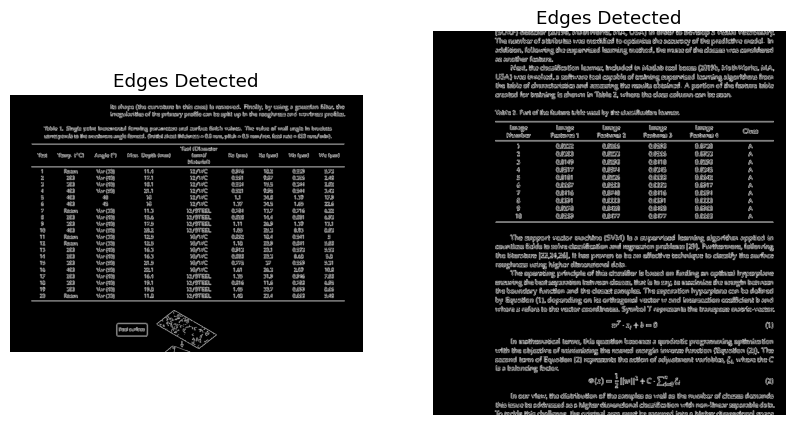

In [32]:
# Crear un subplot para visualizar los bordes detectados en las imágenes
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Detectar y mostrar bordes para las dos primeras imágenes
for i, img in enumerate(images[:2]):
    detect_edges(img, axes[i])

plt.show()

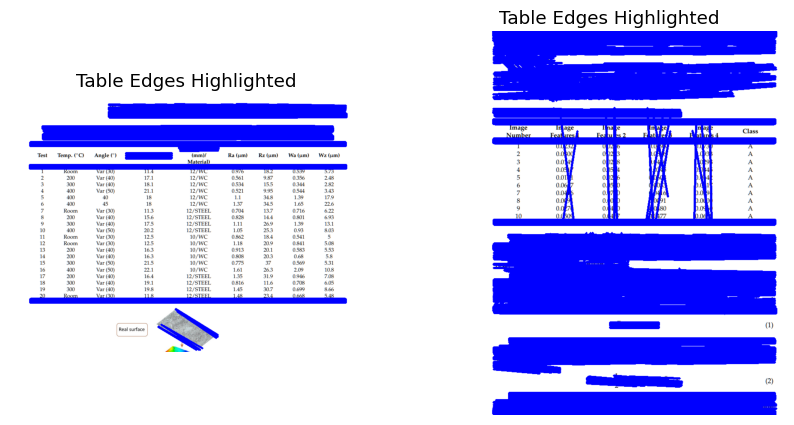

In [37]:
def highlight_table_edges(image, ax):
    # Asegurar que la imagen es un array de NumPy en formato adecuado
    if isinstance(image, Image.Image):
        image = np.array(image)
    
    # Convertir a escala de grises y suavizar la imagen
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Detección de bordes con Canny
    edges = cv2.Canny(blur, 50, 150, apertureSize=3)

    # Transformaciones morfológicas para resaltar líneas horizontales y verticales
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)  # Dilatar para hacer los bordes más gruesos

    # Opcional: Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(dilated, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Dibuja líneas en la imagen original

    # Mostrar los resultados
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB para mostrar correctamente con matplotlib
    ax.set_title("Table Edges Highlighted")
    ax.axis('off')

# Crear un subplot para visualizar las imágenes procesadas
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Aplicar el proceso a las dos primeras imágenes y mostrarlas
for i, img in enumerate(images[:2]):
    highlight_table_edges(img.copy(), axes[i])  # Usar img.copy() para evitar modificar la original

plt.show()

# EVALUACION DEL MODELO

In [48]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

In [43]:
class TableDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith((".png", ".jpg", ".jpeg"))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Convertir a RGB por si acaso
        if self.transform:
            image = self.transform(image)
        return image

# Transformaciones, si es necesario (ajuste según las necesidades del modelo)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Asume tamaño necesario para tu modelo
    transforms.ToTensor(),
])

test_folder = r"C:\Users\ferna\OneDrive\Escritorio\MATERIAS\Human Perception in Computer Vision (MAR24-AGOS24)\Unidad 3\Deberes\PROYCETO\MODELO-PRACTICO\AnalisisModelo\setPruebas"
test_dataset = TableDataset(image_folder=test_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [46]:
# Cargar el modelo
model_path = r'C:\Users\ferna\OneDrive\Escritorio\MATERIAS\Human Perception in Computer Vision (MAR24-AGOS24)\Unidad 3\Deberes\PROYCETO\MODELO-PRACTICO\AnalisisModelo\best.pt'
model = torch.load(model_path)

In [47]:
model

{'epoch': -1,
 'best_fitness': None,
 'model': DetectionModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C2f(
       (cv1): Conv(
         (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track

### Arquitectura del Modelo
- **Modelo:** `DetectionModel`
  - **Secuencial:**
    - Varios bloques de `Conv`, `BatchNorm2d`, y `SiLU` organizados en estructuras como:
      - `C2f` para fusionar características de capas previas.
      - `Bottleneck` para compactar y refinar las características.
      - `SPPF` (Spatial Pyramid Pooling-Fast) para extracción de características multi-escala.
      - `Upsample` y `Concat` para la fusión de características a diferentes escalas.
    - **Detect:**
      - Varios bloques de `Conv` para procesar características finales y determinar detecciones.

### Hiperparámetros de Entrenamiento
- **Épocas:** `100`
- **Tamaño del Lote:** No especificado (`batch: -1` significa valor predeterminado)
- **Tamaño de Imagen:** `640x640`
- **Optimizador:** `SGD`
- **Tasa de Aprendizaje Inicial:** `0.01`
- **Decaimiento del Momentum:** `0.937`
- **Decaimiento del Peso:** `0.001`
- **Augmentaciones:**
  - Rotación, Escala, Corte, etc. especificados por `degrees`, `translate`, `scale`, `shear`, etc.
- **NMS (Non-Max Suppression):** No activado (`nms: False`)
- **Configuraciones Específicas:**
  - `agnostic_nms`, `mosaic`, `mixup` configuraciones para ajustes avanzados en el procesamiento y entrenamiento.

### Información Adicional
- **Fecha de Creación:** `2023-08-05`
- **Versión del Modelo:** `8.0.43`
- **Configuración Específica:** Indica parámetros específicos como `lr0`, `lrf`, `warmup_epochs`, `box`, `cls`, y `dfl` que ajustan la manera en que el modelo aprende a reconocer y clasificar objetos.